In [1]:
import os

os.chdir('/gpfs1/tangfuchou_pkuhpc/tangfuchou_coe/jiangzh/cellTransformer/code/evol/')
from pred import CellTransformer, load_msgpack, map_guide_to_peaks

import pickle
import pandas as pd
import pyranges as pr
import msgpack
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

os.chdir('/gpfs1/tangfuchou_pkuhpc/tangfuchou_coe/jiangzh/cellTransformer/GET/')

def predict(args):
    guide_list, peak_counter = args
    ct = CellTransformer(
        guide_list=guide_list,
        peak_counter=peak_counter,
        target_gene=["GFP"],
        output_dir="./data/get_tmp/",
        celltype="HEK293T",
        motif_bed="../resource/hg38.archetype_motifs.v1.0.bed.gz",
        zarr_path="./data/zarr/HEK293T_hPGK1_AAVS1.zarr"
    )
    score = ct.predict()
    return (guide_list, score)


/gpfs1/tangfuchou_pkuhpc/tangfuchou_coe/jiangzh/software/anaconda3/envs/get/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/gpfs1/tangfuchou_pkuhpc/tangfuchou_coe/jiangzh/software/anaconda3/envs/get/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,
/gpfs1/tangfuchou_pkuhpc/tangfuchou_coe/jiangzh/software/anaconda3/envs/get/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from 

#### Collect kmer information (clear memory after running)

In [2]:
# get candidate guides with high frequency in the ROI
roi = pr.PyRanges(
    chromosomes=["chr19"],
    starts=[int(55115750 - 5e5)],
    ends=[int(55115750 + 5e5)]
)
ref_cCRE_bed = '../resource/CATlas_cCRE_hg38.bed.gz'
roi_cCRE = pr.read_bed(ref_cCRE_bed).overlap(roi)

existing_peaks = pr.read_bed('./data/Hu_2023_NGS_bulk.HEK293T.merged.aCPM.bed')
roi_novel = roi_cCRE.overlap(existing_peaks, invert=True)
roi_novel_name = roi_novel.as_df().apply(lambda x: f"{x['Chromosome']}:{x['Start']}-{x['End']}", axis=1).tolist()

In [ ]:
peak_to_kmer = load_msgpack('./data/index/hg38_CATlas_cCREs.9mer.peak_to_kmer_freq.msgpack')

Loading peak to kmer index...


In [ ]:
kmer_to_peak = load_msgpack('./data/index/hg38_CATlas_cCREs.9mer.kmer_to_peak_freq.msgpack')

Loading kmer to peak index...


In [ ]:
# basic information of global CRE hits by kmer
kmer_cov = {kmer: len(peaks) for kmer, peaks in kmer_to_peak.items() if peaks}
with open('./data/intervention/hg38_CATlas_cCREs.9mer.kmer_cov_by_peak.pkl', 'wb') as f:
    pickle.dump(kmer_cov, f)  # kmer coverage dictionary

In [ ]:
# generate a list of candidate guide RNA 9-mers in ROI
roi_kmer=[i for roi_name in roi_novel_name for i in list(peak_to_kmer[roi_name]['kmer_info'].keys())]
with open('./data/intervention/AAVS1_1Mb_9mer_HEK293T_novel.pkl', 'wb') as f:
    pickle.dump(roi_kmer, f) 

#### Optimization

In [ ]:
# select valid kmer only with coverage < 1e4
with open('./data/intervention/hg38_CATlas_cCREs.9mer.kmer_cov_by_peak.pkl', 'rb') as f:
    kmer_cov = pickle.load(f)

with open('./data/intervention/AAVS1_1Mb_9mer_HEK293T_novel.pkl', 'rb') as f:
    roi_kmer = pickle.load(f)

In [ ]:
kmer_cov_flt = {k: v for k, v in kmer_cov.items() if v < 1e4}
roi_kmer = [k for k in roi_kmer if not 'TTTT' in k]  # exclude Pol-III termination signals
roi_kmer_counts = Counter(k for k in roi_kmer if k in kmer_cov_flt)
input_list = [[kmer] for kmer,count in roi_kmer_counts.items() if count >= 3]


In [ ]:
if __name__ == "__main__":
    # load kmer_to_peak index to generate input of guide RNA targeted cCREs
    peak_counters = [map_guide_to_peaks(guide_list, kmer_to_peak, hit_threshold=1) for guide_list in input_list]

    args_list = list(zip(input_list, peak_counters))
    
    with ProcessPoolExecutor(max_workers=6) as executor:
        results = list(executor.map(predict, args_list))

    with open('test.pkl', 'wb') as f:
        pickle.dump(results, f)

#### Analysis

In [48]:
# load results and make dataframe
with open('non_repetitive_evaluation_results.pkl', 'rb') as f:
    results = pickle.load(f)

df = pd.DataFrame(results, columns=['Guide List', 'Fitness Score'])
df['Guide List'] = df['Guide List'].apply(lambda x: ', '.join(x))
df['Fitness Score'] = df['Fitness Score'].astype(float)
df['hits'] = df['Guide List'].apply(lambda x: sum(kmer_cov.get(k, 0) for k in x.split(', ')))
df['local_hits'] = df['Guide List'].apply(lambda x: roi_kmer_counts.get(x, 0))
df['fold change'] = (np.power(10,df['Fitness Score'])-1) / (10**1.493 - 1)

# find guide target overlapped with TSS of PGK1
pgk1_tss = 'chrX:78103945-78104345'
df['PGK_promoter'] = df['Guide List'].apply(lambda x: pgk1_tss in kmer_to_peak[x].keys())


sorted_df = df.sort_values(by='Fitness Score', ascending=False)
print(f'Total {len(sorted_df)} guides')
print(sorted_df.head(10))  # Display top 10 results

# df.to_csv('250809_HEK293T_hGPK_AAVS1_GFP_single_9-mer_activation.csv', index=False)

Total 2711 guides
    Guide List  Fitness Score  hits  local_hits  fold change  PGK_promoter
433  AGGAGGGGC       1.567387  2060          13     1.193029         False
430  GAGGGAGGA       1.556112  3341          13     1.161604         False
647  GGAGGAGGG       1.545336  3104           7     1.132323         False
569  GGGAGGAGG       1.545215  4545           8     1.131998         False
306  GGGGGCTGC       1.543120  1162           6     1.126391         False
15   GGCCCAGGG       1.542188  1275           5     1.123903         False
298  CACCGCGCC       1.537818  5662           4     1.112319         False
786  CGGCCGCGG       1.537407   521           4     1.111237         False
435  AGGGGCTGG       1.533210  1929           8     1.100230         False
706  GGGGGCAGG       1.532081  1803           5     1.097286         False


In [58]:
#valid = ['GGCAGGGGG', 'GAGGGAGGA', 'AGCAGCAGC']  # global_hits < 1e4 GA, fitness = 1.6526459455490112
#valid = ['CGGCCGCGG', 'GAGGGAGGA', 'GGCCCAGGG']  # global_hits < 1e4 GA , fitness = 1.6533011198043823
#valid = ['GGCAGGGGG', 'AGGAGGGGC', 'AGCAGCAGC']  # global_hits < 1e4 GA, fitness = 1.6586217880249023
valid = ['AGGTAGGGG', 'CACCGCGCC', 'CGGCCGCGG', 'GGCCCAGGG', 'AGGAGGGGC', 'TGACCAACA']  # global_hits < 1e4 GA, fitness = 1.7318919897079468

df[df['Guide List'].isin(valid)]

,Guide List,Fitness Score,hits,local_hits,fold change,PGK_promoter
15,GGCCCAGGG,1.542188,1275,5,1.123903,False
298,CACCGCGCC,1.537818,5662,4,1.112319,False
382,TGACCAACA,1.529273,4645,4,1.090002,False
433,AGGAGGGGC,1.567387,2060,13,1.193029,False
570,AGGTAGGGG,1.515067,440,3,1.053855,False
786,CGGCCGCGG,1.537407,521,4,1.111237,False


In [57]:
valid = ['AGGTAGGGG', 'CGGCCGCGG', 'AGTGTGATG']  # global_hits < 1e3 GA
df[df['Guide List'].isin(valid)]

,Guide List,Fitness Score,hits,local_hits,fold change,PGK_promoter
570,AGGTAGGGG,1.515067,440,3,1.053855,False
613,AGTGTGATG,1.503185,393,3,1.024517,False
786,CGGCCGCGG,1.537407,521,4,1.111237,False


Text(0.5, 1.0, 'Fold Change vs Hits')

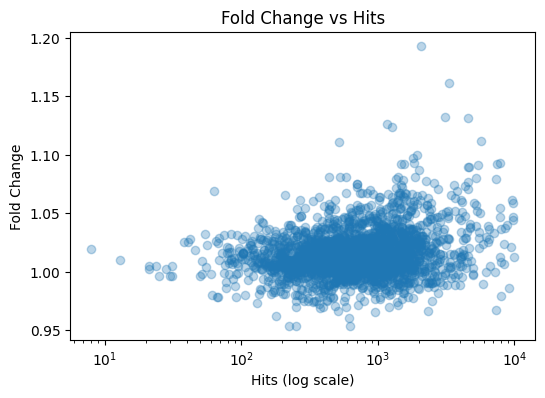

In [ ]:
# scatter of fold change vs log10(hits)
plt.figure(figsize=(6, 4))
plt.scatter(df['hits'], df['fold change'], alpha=0.3)
plt.xscale('log')
plt.xlabel('Hits (log scale)')
plt.ylabel('Fold Change')
plt.title('Fold Change vs Hits')

Text(0.5, 1.0, 'Fold Change vs Local Hits')

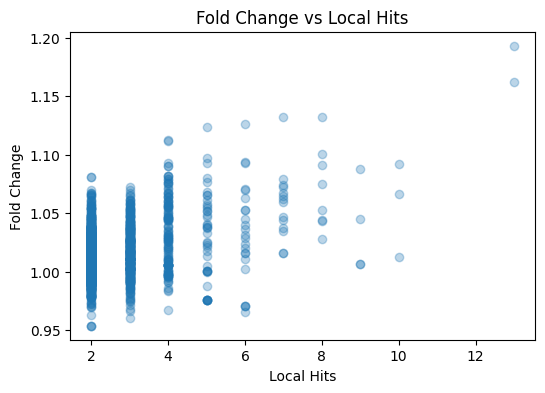

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(df['local_hits'], df['fold change'], alpha=0.3)
plt.xlabel('Local Hits')
plt.ylabel('Fold Change')
plt.title('Fold Change vs Local Hits')